<a href="https://colab.research.google.com/github/alisharifi2000/ImageRetrieval/blob/main/ImageRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# #read all images and change size to 256 * 256
# from PIL import Image
 
# def resize_image(path,save_path):
#     im = Image.open(path)
#     im = im.resize((int(256), int(256)), Image.ANTIALIAS)
#     im.save(save_path)
#     im.close()

In [ ]:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# import glob

# paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
# for path in paths:
#     resize_image(path,path)

# print('resize all images complete !')

resize all images complete !


In [ ]:
len(paths)

1740

In [ ]:
# train VAE AutoEncoder
# use encoder for making image features into latent space

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Bidirectional ,LSTM , Input , Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encoder_layer1 (Conv2D)         (None, 254, 254, 8)  224         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_layer2 (AveragePooling2 (None, 127, 127, 8)  0           encoder_layer1[0][0]             
__________________________________________________________________________________________________
encoder_layer3 (Conv2D)         (None, 125, 125, 16) 1168        encoder_layer2[0][0]             
____________________________________________________________________________________________

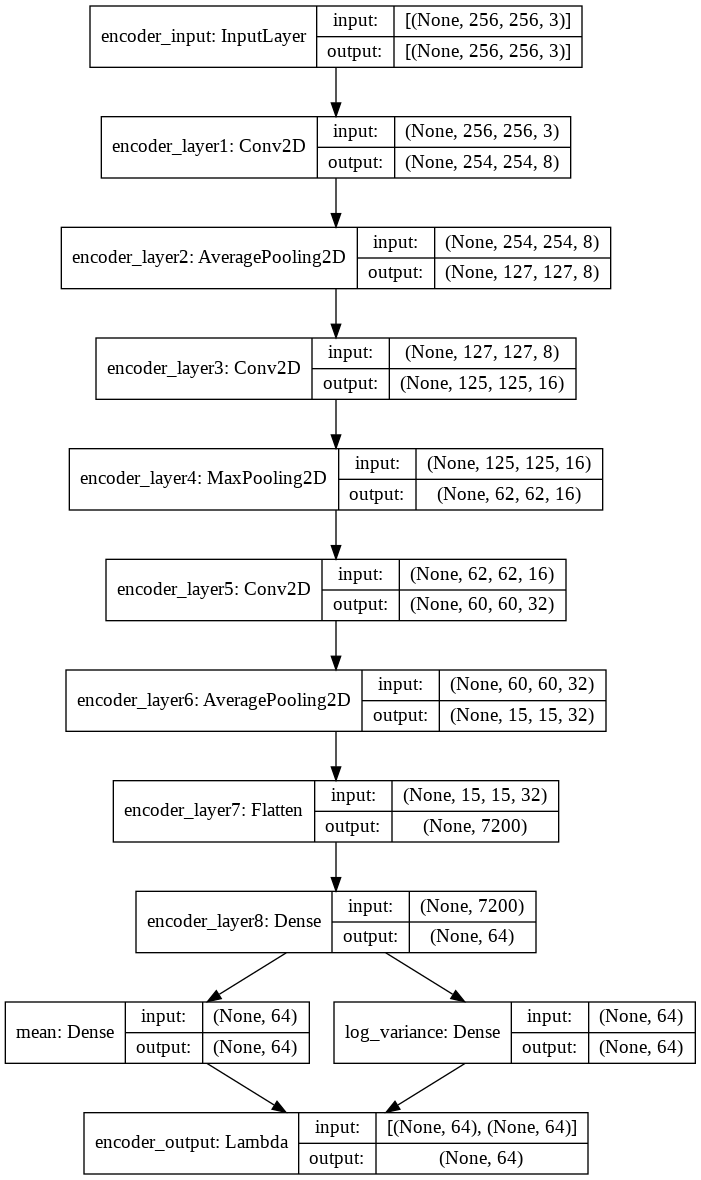

In [ ]:
# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(8,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer2')(encoder)
encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = AveragePooling2D(4,4, name = 'encoder_layer6')(encoder)
encoder = Flatten(name = 'encoder_layer7')(encoder)
encoder = Dense(64 , activation = 'relu', name = 'encoder_layer8')(encoder)

distribution_mean = Dense(64, name='mean')(encoder)
distribution_variance = Dense(64, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')
print(Encoder.summary())
plot_model(Encoder, show_shapes=True)

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
decoder_layer1 (Reshape)     (None, 1, 1, 64)          0         
_________________________________________________________________
decoder_layer2 (Conv2DTransp (None, 3, 3, 32)          18464     
_________________________________________________________________
decoder_layer3 (UpSampling2D (None, 48, 48, 32)        0         
_________________________________________________________________
decoder_layer4 (Conv2DTransp (None, 50, 50, 32)        9248      
_________________________________________________________________
decoder_layer5 (UpSampling2D (None, 400, 400, 32)      0         
_________________________________________________________________
decoder_layer6 (Conv2DTransp (None, 402, 402, 32)      9248

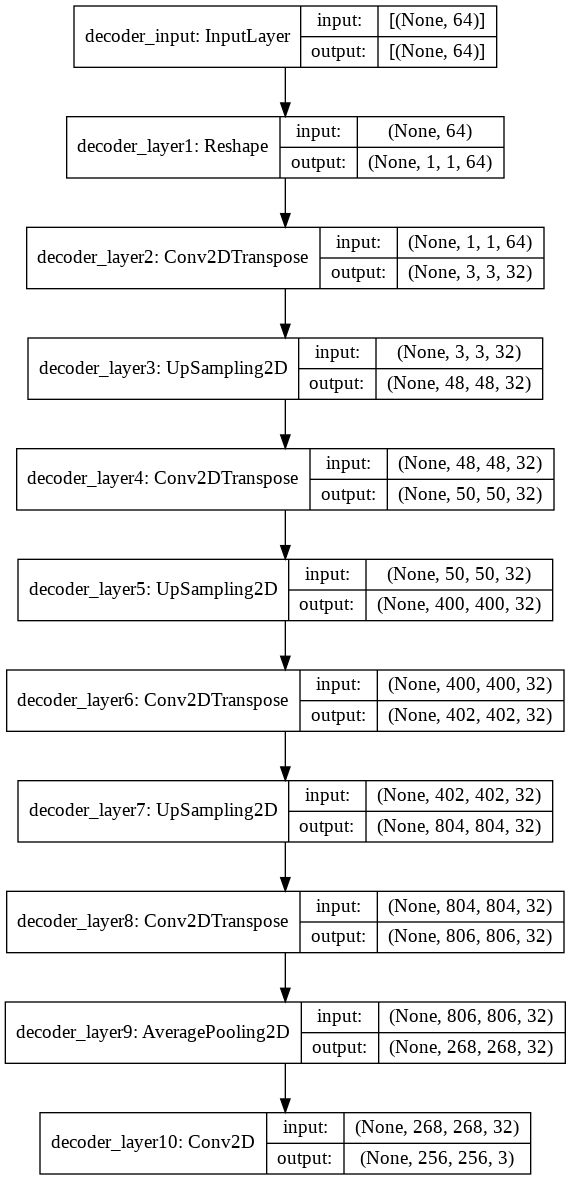

In [ ]:
#VAE decoder

'''
input shape = (128)
'''

input_shape = 64

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 64),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = AveragePooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')
print(Decoder.summary())
plot_model(Decoder, show_shapes=True)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
Encoder (Functional)         (None, 64)                475216    
_________________________________________________________________
Decoder (Functional)         (None, 256, 256, 3)       62435     
Total params: 537,651
Trainable params: 537,651
Non-trainable params: 0
_________________________________________________________________
None


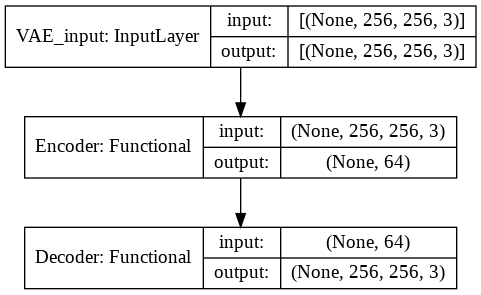

In [ ]:
# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

print(VAE.summary())
plot_model(VAE, show_shapes=True)

In [ ]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv1","block3_conv3" ,'block4_conv1',
                   'block4_conv3','block5_conv1','block5_conv2','block5_conv3','block5_conv4']

selected_layer_weights = [1.0, 2.0 , 2.0 , 4.0 ,4.0,
                         8.0 , 8.0 ,16.0 ,16.0, 16.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0

    img = K.batch_flatten(input_image)
    r_img = K.batch_flatten(reconstruct_image)
    r_error =  K.sum(K.abs(img - r_img), axis=-1) 

    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):

        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.abs(h1 - h2), axis=-1)
        rc_loss = rc_loss / 10

    rc_loss = (rc_loss / (sum(selected_layer_weights)))
    error = (rc_loss + 3*r_error)/4

    return error 

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= perceptual_loss, optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=6)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
## low RAM make data to patches !
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    images.append(img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=30,
    verbose = 1,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [es,cp_callback])

del images
del paths

Epoch 1/30
87/87 [==============================] - 49s 534ms/step - loss: 54464.8472 - val_loss: 41878.0977

Epoch 00001: val_loss improved from inf to 41878.09766, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 2/30
87/87 [==============================] - 45s 521ms/step - loss: 40460.1986 - val_loss: 30869.0742

Epoch 00002: val_loss improved from 41878.09766 to 30869.07422, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 3/30
87/87 [==============================] - 45s 521ms/step - loss: 31494.5484 - val_loss: 30827.3613

Epoch 00003: val_loss improved from 30869.07422 to 30827.36133, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 4/30
87/87 [==============================] - 45s 520ms/step - loss: 30466.5736 - val_loss: 30412.2969

Epoch 00004: val_loss improved from 30827.36133 to 30412.29688, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_RGB256_VAE.h5
Epoch 5/30
87/87 [==

In [ ]:
! ls '/gdrive/MyDrive/ImageRetrieval/Models/'

Best_HSI256_VAE.h5		 LAB256_Encoder_weights.h5
Best_inception256_AE.h5		 LAB256_VAE.h5
Best_LAB256_VAE.h5		 LAB256_VAE_weights.h5
Best_RGB256_VAE.h5		 RGB256_Encoder.h5
Best_XYZ256_VAE.h5		 RGB256_Encoder_weights.h5
HSI256_Encoder.h5		 RGB256_VAE.h5
HSI256_Encoder_weights.h5	 RGB256_VAE_weights.h5
HSI256_VAE.h5			 XYZ256_Encoder.h5
HSI256_VAE_weights.h5		 XYZ256_Encoder_weights.h5
inception256_AE_weights.h5	 XYZ256_VAE.h5
inception256_Encoder_weights.h5  XYZ256_VAE_weights.h5
LAB256_Encoder.h5


In [ ]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder.h5")

In [ ]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder_weights.h5')

In [ ]:
! ls '/gdrive/MyDrive/ImageRetrieval/Models/'

Best_HSI256_VAE.h5		 LAB256_Encoder_weights.h5
Best_inception256_AE.h5		 LAB256_VAE.h5
Best_LAB256_VAE.h5		 LAB256_VAE_weights.h5
Best_RGB256_VAE.h5		 RGB256_Encoder.h5
Best_XYZ256_VAE.h5		 RGB256_Encoder_weights.h5
HSI256_Encoder.h5		 RGB256_VAE.h5
HSI256_Encoder_weights.h5	 RGB256_VAE_weights.h5
HSI256_VAE.h5			 XYZ256_Encoder.h5
HSI256_VAE_weights.h5		 XYZ256_Encoder_weights.h5
inception256_AE_weights.h5	 XYZ256_VAE.h5
inception256_Encoder_weights.h5  XYZ256_VAE_weights.h5
LAB256_Encoder.h5


# save latent vector of RGB in pickle file

In [ ]:
# VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_VAE_weights.h5')
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder_weights.h5')

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)

In [ ]:
## low RAM make data to patches !
counter = 0
data = {}
added = []

for path in paths :
    name = path.split('/')[-1].split('.')[0]
    class_name  = path.split('/')[-3]

    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    img = [img]
    img = np.asarray(img)

    latent = Encoder(img).numpy().reshape(64)
    latent = np.nan_to_num(latent, nan=0)

    id = '{}-{}'.format(class_name,name)

    if id in added:
        print(path)
    else:
        data[id] = {'RGB_features':latent , 'Class':class_name}
        added.append(id)
        counter +=1

print(len(paths))
print(counter)

1740
1740


In [ ]:
# save RGB feature and class of images in pickle file
import pickle

with open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'rb') as handle:
#      print(len(pickle.load(handle).keys()))

In [ ]:
del paths
del data

# save representatives of each class by mean of features

In [ ]:
classes = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*',recursive = True)
list_class = []
for c in classes:
    c = c.split('/')[-1]
    list_class.append(c)

In [ ]:
data = {}
for c in list_class:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/*/*.jpg'.format(c))
    sum = np.zeros(64,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.float32)
        img = img/255.0
        img = [img]
        img = np.asarray(img)
        latent = Encoder(img).numpy().reshape(64)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = sum/len(paths)
    data[c] = {'RGB':sum}

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# HSI features

In [ ]:
## change image to HSI and then use AutoEncoder to reduce dimension

from skimage.color import rgb2hsv

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(8,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer2')(encoder)
encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = AveragePooling2D(4,4, name = 'encoder_layer6')(encoder)
encoder = Flatten(name = 'encoder_layer7')(encoder)
encoder = Dense(64 , activation = 'relu', name = 'encoder_layer8')(encoder)

distribution_mean = Dense(64, name='mean')(encoder)
distribution_variance = Dense(64, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (128)
'''

input_shape = 64

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 64),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = AveragePooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [ ]:
'''
define perceptual_loss
'''

selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv1","block3_conv3" ,'block4_conv1',
                   'block4_conv3','block5_conv1','block5_conv2','block5_conv3','block5_conv4']

selected_layer_weights = [1.0, 1.0 , 1.0 , 2.0 ,2.0,
                         3.0 , 3.0 ,4.0 ,4.0, 5.0]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = Model(vgg.input, outputs)

@tf.function
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0

    img = K.batch_flatten(input_image)
    r_img = K.batch_flatten(reconstruct_image)
    r_error =  K.sum(K.abs(img - r_img), axis=-1) 

    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):

        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.abs(h1 - h2), axis=-1)
        rc_loss = rc_loss / 10

    rc_loss = (rc_loss / 26.0)
    error = (rc_loss + 3*r_error)/4

    return error 

In [ ]:
# perceputal loss good for RGB loss is so BIG!!!
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= perceptual_loss, optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=6)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.astype(np.float32)
    images.append(hsv_img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=30,
    verbose = 1,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [es,cp_callback])

Epoch 1/30
87/87 [==============================] - 48s 528ms/step - loss: 40026.2405 - val_loss: 30811.8828

Epoch 00001: val_loss improved from inf to 30811.88281, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5
Epoch 2/30
87/87 [==============================] - 45s 521ms/step - loss: 29276.6491 - val_loss: 29189.7637

Epoch 00002: val_loss improved from 30811.88281 to 29189.76367, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5
Epoch 3/30
87/87 [==============================] - 45s 520ms/step - loss: 28741.7436 - val_loss: 28979.1094

Epoch 00003: val_loss improved from 29189.76367 to 28979.10938, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5
Epoch 4/30
87/87 [==============================] - 45s 521ms/step - loss: 28420.3981 - val_loss: 28880.8457

Epoch 00004: val_loss improved from 28979.10938 to 28880.84570, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_HSI256_VAE.h5
Epoch 5/30
87/87 [==

In [ ]:
del images
del paths

In [ ]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/HSI256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5")

In [ ]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder_weights.h5')

In [ ]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5')

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.astype(np.float64).reshape(1,256,256,3)
    latent = Encoder(hsv_img).numpy().reshape(64)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'HSI_features':latent})

In [ ]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-0.17812833,  0.37212777, -1.1310701 ,  0.33537936,  0.5802564 ,
        -0.14642787, -1.2465484 , -0.56308913,  0.71313286,  0.59898704,
         0.07730849, -0.6907383 , -0.2860031 ,  0.674686  ,  0.01197079,
         0.48183447,  0.82546324, -2.9972262 , -1.1228862 , -0.02145733,
         0.19926941,  0.5444888 ,  0.23012805,  0.21430653,  0.59568876,
        -2.196142  , -0.16197817, -1.7032446 , -0.793215  ,  0.03182127,
        -1.0913075 ,  0.23802769,  0.5797869 , -1.4717253 , -0.57061523,
        -0.24286401,  0.13980299,  0.05554444, -0.56562996, -1.530935  ,
         0.30818215,  0.3417821 , -1.2453251 , -0.70544773,  0.6671905 ,
        -0.44202083, -0.38108897, -0.24227177, -0.9428719 , -1.1091394 ,
        -0.01852486,  1.4097743 , -1.1120441 ,  0.08142884, -0.97913057,
        -1.5550326 , -0.2748984 , -1.6345724 ,  1.157543  ,  0.00596564,
        -0.3912971 , -0.33938825,  0.4434489 ,  1.0437015 ], dtype=float32),
 'RGB_feature

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/features1.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(64,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        hsv_img = rgb2hsv(img)
        hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
        hsv_img = hsv_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(hsv_img).numpy().reshape(64)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'HSI':sum})

In [ ]:
data['lion']

{'HSI': array([ 0.1492762 ,  0.2633912 ,  0.46199462, -0.10007707,  0.4680749 ,
         1.13425   , -0.5266292 ,  0.5943809 ,  0.25622612,  0.4648542 ,
         0.22927715, -1.2788681 , -0.62736756,  0.0398203 , -0.13232906,
         0.25461307,  0.13292469, -1.887102  ,  0.537627  , -0.06311138,
         0.3393129 , -0.10818697, -0.30131742,  0.40037513,  0.50632536,
        -1.9639274 ,  0.04382346, -1.2270705 , -0.7308    , -0.09887905,
        -1.0610863 ,  0.75797755, -0.45577022, -1.472138  , -0.25489902,
        -0.9682249 , -0.36585784,  0.34378314,  0.12613672, -0.85120344,
        -0.21466185,  0.6654489 , -1.309146  , -0.26215178,  1.2039739 ,
         0.06154291, -0.6415315 , -0.33119985, -0.7463157 , -1.0136424 ,
        -0.3549541 ,  1.0206946 , -0.11711545,  0.04088916, -0.8476073 ,
        -1.2731954 ,  0.7775606 , -0.49178824,  1.0942887 , -0.26612437,
         0.31534103, -0.05186249,  0.56495064,  0.8779201 ], dtype=float32),
 'RGB': array([ -1.9233102 ,  -1.806939 

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives1.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# LAB color

In [ ]:
from skimage.color import rgb2lab

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(8,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer2')(encoder)
encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = AveragePooling2D(4,4, name = 'encoder_layer6')(encoder)
encoder = Flatten(name = 'encoder_layer7')(encoder)
encoder = Dense(64 , activation = 'relu', name = 'encoder_layer8')(encoder)

distribution_mean = Dense(64, name='mean')(encoder)
distribution_variance = Dense(64, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (128)
'''

input_shape = 64

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 64),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = AveragePooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [ ]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= 'mae', optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=6)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_LAB256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    lab_img = rgb2lab(img)
    lab_img = lab_img.astype(np.float64)
    images.append(lab_img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=30,
    verbose = 1,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [es,cp_callback])

Epoch 1/30
87/87 [==============================] - 30s 343ms/step - loss: 2235.1857 - val_loss: 2152.8491

Epoch 00001: val_loss improved from inf to 2152.84912, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_LAB256_VAE.h5
Epoch 2/30
87/87 [==============================] - 29s 336ms/step - loss: 2205.6983 - val_loss: 2152.8491

Epoch 00002: val_loss did not improve from 2152.84912
Epoch 3/30
87/87 [==============================] - 29s 337ms/step - loss: 2212.2146 - val_loss: 2152.8491

Epoch 00003: val_loss did not improve from 2152.84912
Epoch 4/30
87/87 [==============================] - 29s 337ms/step - loss: 2219.9611 - val_loss: 2152.8491

Epoch 00004: val_loss did not improve from 2152.84912
Epoch 5/30
87/87 [==============================] - 29s 337ms/step - loss: 2212.8788 - val_loss: 2152.8491

Epoch 00005: val_loss did not improve from 2152.84912
Epoch 6/30
87/87 [==============================] - 29s 337ms/step - loss: 2221.0564 - val_loss: 2152.8491

Epoch 00

In [ ]:
del images
del paths

In [ ]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/LAB256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5")

In [ ]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder_weights.h5')

In [ ]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5')

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features1.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    lab_img = rgb2lab(img)
    lab_img = lab_img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(lab_img).numpy().reshape(64)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'LAB_features':latent})

In [ ]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-0.17812833,  0.37212777, -1.1310701 ,  0.33537936,  0.5802564 ,
        -0.14642787, -1.2465484 , -0.56308913,  0.71313286,  0.59898704,
         0.07730849, -0.6907383 , -0.2860031 ,  0.674686  ,  0.01197079,
         0.48183447,  0.82546324, -2.9972262 , -1.1228862 , -0.02145733,
         0.19926941,  0.5444888 ,  0.23012805,  0.21430653,  0.59568876,
        -2.196142  , -0.16197817, -1.7032446 , -0.793215  ,  0.03182127,
        -1.0913075 ,  0.23802769,  0.5797869 , -1.4717253 , -0.57061523,
        -0.24286401,  0.13980299,  0.05554444, -0.56562996, -1.530935  ,
         0.30818215,  0.3417821 , -1.2453251 , -0.70544773,  0.6671905 ,
        -0.44202083, -0.38108897, -0.24227177, -0.9428719 , -1.1091394 ,
        -0.01852486,  1.4097743 , -1.1120441 ,  0.08142884, -0.97913057,
        -1.5550326 , -0.2748984 , -1.6345724 ,  1.157543  ,  0.00596564,
        -0.3912971 , -0.33938825,  0.4434489 ,  1.0437015 ], dtype=float32),
 'LAB_feature

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/features2.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives1.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(64,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        lab_img = rgb2lab(img)
        lab_img = lab_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(lab_img).numpy().reshape(64)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'LAB':sum})

In [ ]:
data['lion']

{'HSI': array([ 0.1492762 ,  0.2633912 ,  0.46199462, -0.10007707,  0.4680749 ,
         1.13425   , -0.5266292 ,  0.5943809 ,  0.25622612,  0.4648542 ,
         0.22927715, -1.2788681 , -0.62736756,  0.0398203 , -0.13232906,
         0.25461307,  0.13292469, -1.887102  ,  0.537627  , -0.06311138,
         0.3393129 , -0.10818697, -0.30131742,  0.40037513,  0.50632536,
        -1.9639274 ,  0.04382346, -1.2270705 , -0.7308    , -0.09887905,
        -1.0610863 ,  0.75797755, -0.45577022, -1.472138  , -0.25489902,
        -0.9682249 , -0.36585784,  0.34378314,  0.12613672, -0.85120344,
        -0.21466185,  0.6654489 , -1.309146  , -0.26215178,  1.2039739 ,
         0.06154291, -0.6415315 , -0.33119985, -0.7463157 , -1.0136424 ,
        -0.3549541 ,  1.0206946 , -0.11711545,  0.04088916, -0.8476073 ,
        -1.2731954 ,  0.7775606 , -0.49178824,  1.0942887 , -0.26612437,
         0.31534103, -0.05186249,  0.56495064,  0.8779201 ], dtype=float32),
 'LAB': array([-0.14053695,  0.1046054 ,

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives2.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# XYZ color

In [ ]:
from skimage.color import rgb2xyz

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

# VAE encoder 
'''
input shape = (256,256,3)
'''

input_shape = (256,256,3)

input_encoder = Input(input_shape,name = 'encoder_input')
encoder = Conv2D(8,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
encoder = AveragePooling2D(2,2 , name = 'encoder_layer2')(encoder)
encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
encoder = AveragePooling2D(4,4, name = 'encoder_layer6')(encoder)
encoder = Flatten(name = 'encoder_layer7')(encoder)
encoder = Dense(64 , activation = 'relu', name = 'encoder_layer8')(encoder)

distribution_mean = Dense(64, name='mean')(encoder)
distribution_variance = Dense(64, name='log_variance')(encoder)

latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

#VAE decoder

'''
input shape = (128)
'''

input_shape = 64

input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 64),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = AveragePooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')


# VAE Model
VAE_input = Input((256,256,3),name = 'VAE_input')
VAE_latent = Encoder(VAE_input)
VAE_output = Decoder(VAE_latent)
VAE = Model(inputs= [VAE_input], outputs=[VAE_output],name = 'VAE')

In [ ]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
VAE.compile(loss= 'mae', optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=6)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_XYZ256_VAE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.astype(np.float32)
    images.append(xyz_img)
images = np.asarray(images)

VAE.fit(x=images,y=images,
    epochs=30,
    verbose = 1,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [es,cp_callback])

Epoch 1/30
87/87 [==============================] - 30s 339ms/step - loss: 103112.4139 - val_loss: 98211.3438

Epoch 00001: val_loss improved from inf to 98211.34375, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_XYZ256_VAE.h5
Epoch 2/30
87/87 [==============================] - 29s 336ms/step - loss: 103245.7951 - val_loss: 98211.3438

Epoch 00002: val_loss did not improve from 98211.34375
Epoch 3/30
87/87 [==============================] - 29s 338ms/step - loss: 102127.7908 - val_loss: 98211.3438

Epoch 00003: val_loss did not improve from 98211.34375
Epoch 4/30
87/87 [==============================] - 29s 335ms/step - loss: 104613.7470 - val_loss: 98211.3438

Epoch 00004: val_loss did not improve from 98211.34375
Epoch 5/30
87/87 [==============================] - 29s 336ms/step - loss: 101666.6850 - val_loss: 98211.3438

Epoch 00005: val_loss did not improve from 98211.34375
Epoch 6/30
87/87 [==============================] - 29s 336ms/step - loss: 101263.5782 - val_los

In [ ]:
VAE.save("/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_VAE.h5")
Encoder.save("/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5")

In [ ]:
VAE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_VAE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder_weights.h5')

In [ ]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5')

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features2.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(xyz_img).numpy().reshape(64)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'XYZ_features':latent})

In [ ]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-0.17812833,  0.37212777, -1.1310701 ,  0.33537936,  0.5802564 ,
        -0.14642787, -1.2465484 , -0.56308913,  0.71313286,  0.59898704,
         0.07730849, -0.6907383 , -0.2860031 ,  0.674686  ,  0.01197079,
         0.48183447,  0.82546324, -2.9972262 , -1.1228862 , -0.02145733,
         0.19926941,  0.5444888 ,  0.23012805,  0.21430653,  0.59568876,
        -2.196142  , -0.16197817, -1.7032446 , -0.793215  ,  0.03182127,
        -1.0913075 ,  0.23802769,  0.5797869 , -1.4717253 , -0.57061523,
        -0.24286401,  0.13980299,  0.05554444, -0.56562996, -1.530935  ,
         0.30818215,  0.3417821 , -1.2453251 , -0.70544773,  0.6671905 ,
        -0.44202083, -0.38108897, -0.24227177, -0.9428719 , -1.1091394 ,
        -0.01852486,  1.4097743 , -1.1120441 ,  0.08142884, -0.97913057,
        -1.5550326 , -0.2748984 , -1.6345724 ,  1.157543  ,  0.00596564,
        -0.3912971 , -0.33938825,  0.4434489 ,  1.0437015 ], dtype=float32),
 'LAB_feature

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/features3.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives2.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(64,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        xyz_img = rgb2xyz(img)
        xyz_img = xyz_img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(xyz_img).numpy().reshape(64)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'XYZ':sum})

In [ ]:
data['lion']

{'HSI': array([ 0.1492762 ,  0.2633912 ,  0.46199462, -0.10007707,  0.4680749 ,
         1.13425   , -0.5266292 ,  0.5943809 ,  0.25622612,  0.4648542 ,
         0.22927715, -1.2788681 , -0.62736756,  0.0398203 , -0.13232906,
         0.25461307,  0.13292469, -1.887102  ,  0.537627  , -0.06311138,
         0.3393129 , -0.10818697, -0.30131742,  0.40037513,  0.50632536,
        -1.9639274 ,  0.04382346, -1.2270705 , -0.7308    , -0.09887905,
        -1.0610863 ,  0.75797755, -0.45577022, -1.472138  , -0.25489902,
        -0.9682249 , -0.36585784,  0.34378314,  0.12613672, -0.85120344,
        -0.21466185,  0.6654489 , -1.309146  , -0.26215178,  1.2039739 ,
         0.06154291, -0.6415315 , -0.33119985, -0.7463157 , -1.0136424 ,
        -0.3549541 ,  1.0206946 , -0.11711545,  0.04088916, -0.8476073 ,
        -1.2731954 ,  0.7775606 , -0.49178824,  1.0942887 , -0.26612437,
         0.31534103, -0.05186249,  0.56495064,  0.8779201 ], dtype=float32),
 'LAB': array([-0.14053695,  0.1046054 ,

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives3.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
del data

# use InceptionV3 for summurize input image

In [ ]:
from keras.applications.inception_v3 import InceptionV3
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense ,Dropout, Input , Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob


inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
inception.trainable = False
base_out = inception.output
top_fc1 = Flatten()(base_out)
top_fc2 = Dropout(0.5)(top_fc1)
encoder_output = Dense(256, activation="relu")(top_fc2)
Encoder = Model(inputs= [inception.input], outputs=[encoder_output],name = 'Encoder')


input_shape = 256
input_decoder = Input(input_shape,name = 'decoder_input')
decoder = Reshape((1, 1, 256),name = 'decoder_layer1')(input_decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer2')(decoder)
decoder = UpSampling2D(16,name = 'decoder_layer3')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer4')(decoder)
decoder = UpSampling2D(8,name = 'decoder_layer5')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer6')(decoder)
decoder = UpSampling2D(2,name = 'decoder_layer7')(decoder)
decoder = Conv2DTranspose(32, (3,3), activation='relu' , name = 'decoder_layer8')(decoder)
decoder = AveragePooling2D((3,3), name = 'decoder_layer9')(decoder)
output_decoder = Conv2D(3,(13,13), name = 'decoder_layer10' , activation= 'relu')(decoder)

Decoder = Model(inputs= [input_decoder], outputs=[output_decoder],name = 'Decoder')

# VAE Model
AE_input = Input((256,256,3),name = 'AE_input')
AE_latent = Encoder(AE_input)
AE_output = Decoder(AE_latent)
AE = Model(inputs= [AE_input], outputs=[AE_output],name = 'AE')

In [ ]:
rmsprop = RMSprop(learning_rate=0.00025 , momentum=0.99)
AE.compile(loss= 'mse', optimizer= rmsprop)

es = EarlyStopping(monitor="val_loss",
                   patience=10)

cp_callback = ModelCheckpoint(filepath='/gdrive/MyDrive/ImageRetrieval/Models/Best_inception256_AE.h5',
                              monitor='val_loss',
                              save_weights_only=True,
                              save_best_only=True,
                              verbose=1)

In [ ]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [ ]:
images = []
for path in paths :
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32)
    img = img/255.0
    images.append(img)
images = np.asarray(images)

In [ ]:
AE.fit(x=images,y=images,
    epochs=100,
    verbose = 1,
    batch_size = 16,
    validation_split = 0.2,
    callbacks = [es,cp_callback])

Epoch 1/100
87/87 [==============================] - 37s 384ms/step - loss: 0.3766 - val_loss: 0.2313

Epoch 00001: val_loss improved from inf to 0.23126, saving model to /gdrive/MyDrive/ImageRetrieval/Models/Best_inception256_AE.h5
Epoch 2/100
87/87 [==============================] - 32s 373ms/step - loss: 0.2326 - val_loss: 0.2313

Epoch 00002: val_loss did not improve from 0.23126
Epoch 3/100
87/87 [==============================] - 32s 373ms/step - loss: 0.2294 - val_loss: 0.2313

Epoch 00003: val_loss did not improve from 0.23126
Epoch 4/100
87/87 [==============================] - 32s 372ms/step - loss: 0.2309 - val_loss: 0.2313

Epoch 00004: val_loss did not improve from 0.23126
Epoch 5/100
87/87 [==============================] - 32s 373ms/step - loss: 0.2311 - val_loss: 0.2313

Epoch 00005: val_loss did not improve from 0.23126
Epoch 6/100
87/87 [==============================] - 32s 373ms/step - loss: 0.2324 - val_loss: 0.2313

Epoch 00006: val_loss did not improve from 0.231

In [ ]:
AE.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_AE_weights.h5')
Encoder.save_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [ ]:
Encoder.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [ ]:
import pickle
handle = open('/gdrive/MyDrive/ImageRetrieval/features3.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)
    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.float32).reshape(1,256,256,3)
    latent = Encoder(img).numpy().reshape(256)
    latent = np.nan_to_num(latent, nan=0)
    data[id].update({'inception_features':latent})

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/features4.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives3.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    sum = np.zeros(256,dtype=np.float32)
    for path in paths:
        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.float32).reshape(1,256,256,3)
        latent = Encoder(img).numpy().reshape(256)
        latent = np.nan_to_num(latent, nan=0)
        sum = sum + latent
    sum = (sum / len(paths))
    data[id].update({'inception':sum})

In [ ]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives4.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

# TEXTURE

In [77]:
from skimage.feature.texture import greycomatrix
from skimage.feature.texture import greycoprops
import glob
from random import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import pickle
import numpy as np
from skimage.color import rgb2gray

In [78]:
paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/*/*/*.jpg',recursive = True)
shuffle(paths)
len(paths)

1740

In [79]:
handle = open('/gdrive/MyDrive/ImageRetrieval/features4.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())
for id in ids:
    c = id.split('-')[0]
    name = id.split('-')[1]

    path = '/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/{}.jpg'.format(c,name)

    img = load_img(path)
    img = img_to_array(img)
    img = img.astype(np.uint8)
    img = rgb2gray(img)
    img = img.astype(np.uint8)
    
    distance = [1,2,3]
    angles = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
    levels = [4,16,64,256]
    setups =  [(d, a , l) for d in distance for a in angles for l in levels] 

    contrast_list = []
    dis_list = []
    homogeneity_list = []
    energy_list = []
    correlation_list = []

    for setup in setups:
        glcm = greycomatrix(img, [setup[0]], [setup[1]],levels = setup[2] , normed=True, symmetric=True)
        contrast = greycoprops(glcm, 'contrast').reshape(1)
        contrast_list.append(contrast)
        dissimilarity = greycoprops(glcm, 'dissimilarity').reshape(1)
        dis_list.append(dissimilarity)
        homogeneity = greycoprops(glcm, 'homogeneity').reshape(1)
        homogeneity_list.append(homogeneity)
        energy = greycoprops(glcm, 'energy').reshape(1)
        energy_list.append(energy)
        correlation = greycoprops(glcm, 'correlation').reshape(1)
        correlation_list.append(correlation)

    contrast_list = np.array(contrast_list).reshape(60)
    dis_list = np.array(dis_list).reshape(60)
    homogeneity_list = np.array(homogeneity_list).reshape(60)
    energy_list = np.array(energy_list).reshape(60)
    correlation_list = np.array(correlation_list).reshape(60)

    data[id].update({'contrast' : contrast_list , 'dissimilarity': dis_list , 
                     "homogeneity" : homogeneity_list,'energy':energy_list ,
                     "correlation":correlation_list })

In [80]:
data[list(data.keys())[0]]

{'Class': 'bear',
 'HSI_features': array([-0.17812833,  0.37212777, -1.1310701 ,  0.33537936,  0.5802564 ,
        -0.14642787, -1.2465484 , -0.56308913,  0.71313286,  0.59898704,
         0.07730849, -0.6907383 , -0.2860031 ,  0.674686  ,  0.01197079,
         0.48183447,  0.82546324, -2.9972262 , -1.1228862 , -0.02145733,
         0.19926941,  0.5444888 ,  0.23012805,  0.21430653,  0.59568876,
        -2.196142  , -0.16197817, -1.7032446 , -0.793215  ,  0.03182127,
        -1.0913075 ,  0.23802769,  0.5797869 , -1.4717253 , -0.57061523,
        -0.24286401,  0.13980299,  0.05554444, -0.56562996, -1.530935  ,
         0.30818215,  0.3417821 , -1.2453251 , -0.70544773,  0.6671905 ,
        -0.44202083, -0.38108897, -0.24227177, -0.9428719 , -1.1091394 ,
        -0.01852486,  1.4097743 , -1.1120441 ,  0.08142884, -0.97913057,
        -1.5550326 , -0.2748984 , -1.6345724 ,  1.157543  ,  0.00596564,
        -0.3912971 , -0.33938825,  0.4434489 ,  1.0437015 ], dtype=float32),
 'LAB_feature

In [81]:
with open('/gdrive/MyDrive/ImageRetrieval/features5.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives4.pickle', 'rb')
data = pickle.load(handle)
ids = list(data.keys())

sum_con = [0] * 60
sum_dis = [0] * 60
sum_cor = [0] * 60
sum_enr = [0] * 60
sum_hem = [0] * 60

distance = [1,2,3]
angles = [0,np.pi/2,np.pi,3*np.pi/2,2*np.pi]
levels = [4,16,64,256]
setups =  [(d, a , l) for d in distance for a in angles for l in levels] 

for id in ids:
    paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/animal_database/{}/original/*.jpg'.format(c))
    for path in paths:

        img = load_img(path)
        img = img_to_array(img)
        img = img.astype(np.uint8)
        img = rgb2gray(img)
        img = img.astype(np.uint8)

        for index ,setup in enumerate(setups):
            glcm = greycomatrix(img, [setup[0]], [setup[1]],levels = setup[2] , normed=True, symmetric=True)

            contrast = greycoprops(glcm, 'contrast').reshape(1)
            dissimilarity = greycoprops(glcm, 'dissimilarity').reshape(1)
            homogeneity = greycoprops(glcm, 'homogeneity').reshape(1)
            energy = greycoprops(glcm, 'energy').reshape(1)
            correlation = greycoprops(glcm, 'correlation').reshape(1)

            sum_con[index] = sum_con[index] + contrast
            sum_dis[index] = sum_dis[index] + dissimilarity
            sum_hem[index] = sum_hem[index] + homogeneity
            sum_enr[index] = sum_enr[index] + energy
            sum_cor[index] = sum_cor[index] + correlation

    sum_con = np.array(sum_con).reshape(60)
    sum_con = sum_con/len(paths)

    sum_dis = np.array(sum_dis).reshape(60)
    sum_dis = sum_dis/len(paths)

    sum_hem = np.array(sum_hem).reshape(60)
    sum_hem = sum_hem/len(paths)

    sum_enr = np.array(sum_enr).reshape(60)
    sum_enr = sum_enr/len(paths)

    sum_cor = np.array(sum_cor).reshape(60)
    sum_cor = sum_cor/len(paths)

    data[id].update({'contrast':sum_con , 'dissimilarity' : sum_dis,
                     'homogeneity':sum_hem ,'energy':sum_enr ,
                     'correlation' : sum_cor})

In [83]:
data['lion']

{'HSI': array([ 0.1492762 ,  0.2633912 ,  0.46199462, -0.10007707,  0.4680749 ,
         1.13425   , -0.5266292 ,  0.5943809 ,  0.25622612,  0.4648542 ,
         0.22927715, -1.2788681 , -0.62736756,  0.0398203 , -0.13232906,
         0.25461307,  0.13292469, -1.887102  ,  0.537627  , -0.06311138,
         0.3393129 , -0.10818697, -0.30131742,  0.40037513,  0.50632536,
        -1.9639274 ,  0.04382346, -1.2270705 , -0.7308    , -0.09887905,
        -1.0610863 ,  0.75797755, -0.45577022, -1.472138  , -0.25489902,
        -0.9682249 , -0.36585784,  0.34378314,  0.12613672, -0.85120344,
        -0.21466185,  0.6654489 , -1.309146  , -0.26215178,  1.2039739 ,
         0.06154291, -0.6415315 , -0.33119985, -0.7463157 , -1.0136424 ,
        -0.3549541 ,  1.0206946 , -0.11711545,  0.04088916, -0.8476073 ,
        -1.2731954 ,  0.7775606 , -0.49178824,  1.0942887 , -0.26612437,
         0.31534103, -0.05186249,  0.56495064,  0.8779201 ], dtype=float32),
 'LAB': array([-0.14053695,  0.1046054 ,

In [84]:
with open('/gdrive/MyDrive/ImageRetrieval/representatives5.pickle', 'wb') as handle1:
    pickle.dump(data, handle1, protocol=pickle.HIGHEST_PROTOCOL)

# input image 

In [ ]:
'''
resize image to 256 * 256
go to latent space by VAE of each features
find distance betweens representatives to choose class
find most similar image to input image 
choose top 9 image
'''

'\nresize image to 256 * 256\ngo to latent space by VAE of each features\nfind distance betweens representatives to choose class\nfind most similar image to input image \nchoose top 9 image\n'

In [ ]:
# train VAE AutoEncoder
# use encoder for making image features into latent space

import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Bidirectional ,LSTM , Input , Conv2D  ,MaxPooling2D ,AveragePooling2D ,Flatten , Lambda , UpSampling2D ,Conv2DTranspose ,Reshape 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.losses import mean_absolute_error
from random import shuffle
from keras.models import load_model
import glob

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

def make_Encoder_model():

    # VAE encoder 
    '''
    input shape = (256,256,3)
    '''

    input_shape = (256,256,3)

    input_encoder = Input(input_shape,name = 'encoder_input')
    encoder = Conv2D(8,(3,3),activation = 'relu',name = 'encoder_layer1')(input_encoder)
    encoder = AveragePooling2D(2,2 , name = 'encoder_layer2')(encoder)
    encoder = Conv2D(16,(3,3),activation = 'relu',name = 'encoder_layer3')(encoder)
    encoder = MaxPooling2D(2,2 , name = 'encoder_layer4')(encoder)
    encoder = Conv2D(32,(3,3),activation = 'relu',name = 'encoder_layer5')(encoder)
    encoder = AveragePooling2D(4,4, name = 'encoder_layer6')(encoder)
    encoder = Flatten(name = 'encoder_layer7')(encoder)
    encoder = Dense(64 , activation = 'relu', name = 'encoder_layer8')(encoder)

    distribution_mean = Dense(64, name='mean')(encoder)
    distribution_variance = Dense(64, name='log_variance')(encoder)

    latent_encoding = Lambda(sample_latent_features , name = 'encoder_output')([distribution_mean, distribution_variance])

    Encoder = Model(inputs= [input_encoder], outputs=[latent_encoding],name = 'Encoder')

    return Encoder

In [ ]:
def make_AE():
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
    inception.trainable = False
    base_out = inception.output
    top_fc1 = Flatten()(base_out)
    top_fc2 = Dropout(0.5)(top_fc1)
    encoder_output = Dense(256, activation="relu")(top_fc2)
    Encoder = Model(inputs= [inception.input], outputs=[encoder_output],name = 'Encoder')

    return Encoder

In [ ]:
AE = make_AE()
AE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/inception256_Encoder_weights.h5')

In [ ]:
RGB_VAE = make_Encoder_model()
RGB_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/RGB256_Encoder.h5')

In [ ]:
HSI_VAE = make_Encoder_model()
HSI_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/HSI256_Encoder.h5')

In [ ]:
LAB_VAE = make_Encoder_model()
LAB_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/LAB256_Encoder.h5')

In [ ]:
XYZ_VAE = make_Encoder_model()
XYZ_VAE.load_weights('/gdrive/MyDrive/ImageRetrieval/Models/XYZ256_Encoder.h5')

In [ ]:
import pickle
handle = open('/gdrive/MyDrive/ImageRetrieval/representatives4.pickle', 'rb')
representives = pickle.load(handle)
representives['bear'].keys()

dict_keys(['RGB', 'HSI', 'LAB', 'XYZ', 'inception'])

In [ ]:
from skimage.color import rgb2hsv
from skimage.color import rgb2xyz
from skimage.color import rgb2lab
from PIL import Image

paths = glob.glob('/gdrive/MyDrive/ImageRetrieval/test_images/*.jpg')

for path in paths :
    im = Image.open(path)
    im = im.resize((int(256), int(256)), Image.ANTIALIAS)
    im.save(path)
    im.close()

    img_name = path.split('/')[-1]

    # color features:

    img = load_img(path)
    img = img_to_array(img)


    rgb_img = img/255.0
    rgb_img = rgb_img.reshape(1,256,256,3)
    rgb_img = rgb_img.astype(np.float32)


    hsv_img = rgb2hsv(img)
    hsv_img[:,:,2] = hsv_img[:,:,2]/255.0
    hsv_img = hsv_img.reshape(1,256,256,3)
    hsv_img = hsv_img.astype(np.float32)

    lab_img = rgb2lab(img)
    lab_img = lab_img.reshape(1,256,256,3)
    lab_img = lab_img.astype(np.float64)

    xyz_img = rgb2xyz(img)
    xyz_img = xyz_img.reshape(1,256,256,3)
    xyz_img = xyz_img.astype(np.float32)

    latent_RGB = RGB_VAE(rgb_img).numpy().reshape(64)
    latent_RGB = np.nan_to_num(latent_RGB, nan=0)
    latent_inception = AE(rgb_img).numpy().reshape(256)
    latent_inception = np.nan_to_num(latent_inception, nan=0)
    latent_HSI = HSI_VAE(hsv_img).numpy().reshape(64)
    latent_HSI = np.nan_to_num(latent_HSI, nan=0)
    latent_LAB = LAB_VAE(hsv_img).numpy().reshape(64)
    latent_LAB = np.nan_to_num(latent_LAB, nan=0)
    latent_XYZ = XYZ_VAE(xyz_img).numpy().reshape(64)
    latent_XYZ = np.nan_to_num(latent_XYZ, nan=0)


    # texture features : 



    class_name = ''
    score_class = np.inf
    for c in list(representives.keys()):

        class_info = representives[c]

        # distance Color features

        rgb_info = class_info['RGB']
        rgb_info = np.nan_to_num(rgb_info, nan=0)
        hsi_info = class_info['HSI']
        hsi_info = np.nan_to_num(hsi_info, nan=0)
        lab_info = class_info['LAB']
        lab_info = np.nan_to_num(lab_info, nan=0)
        xyz_info = class_info['XYZ']
        xyz_info = np.nan_to_num(xyz_info, nan=0)
        inception_info = class_info['inception']
        inception_info = np.nan_to_num(inception_info, nan=0)

        rgb_score = np.sum(np.abs(rgb_info - latent_RGB))
        hsi_score = np.sum(np.abs(hsi_info - latent_HSI))
        lab_score = np.sum(np.abs(lab_info - latent_LAB))
        xyz_score = np.sum(np.abs(xyz_info - latent_XYZ))
        inception_score = np.sum(np.abs(inception_info - latent_inception))


        color_score = (inception_score + rgb_score + hsi_score + xyz_score + lab_score)/(5)

        # distance Texture features

        if score < score_class:
            score_class = score
            class_name = c

    print('image {} , reltated to {} , difference {}'.format(img_name,class_name,score))

image lion1.jpg , reltated to giraffe , difference 118025.0625
image bear2.jpg , reltated to lion , difference 118713.65
image cow3.jpg , reltated to sheep , difference 117613.9125
image elephent1.jpg , reltated to goat , difference 116334.8
image tiger3.jpg , reltated to sheep , difference 119390.5125
image tiger2.jpg , reltated to tiger , difference 119070.5625
image cow2.jpg , reltated to horse , difference 117032.7
image cow1.jpg , reltated to panda , difference 116129.2
image lion2.jpg , reltated to coyote , difference 116243.75
image bear1.jpg , reltated to goat , difference 117707.825
image tiger1.jpg , reltated to coyote , difference 118256.2125
image tiger4.jpg , reltated to gorilla , difference 117959.35
